In [1]:
%matplotlib inline  
import os
import pandas as pd
import yfinance as yf
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import logging
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from scipy.signal import savgol_filter
import datetime
logger = logging.getLogger()


In [3]:
# make the ticker list
# "custom_ticker_pool.csv" is a list of tickers that you want to include specifically
# even if they're not included in the Russell 1000 or S&P 500
files = ['custom_ticker_pool.csv', 'russell1000.csv', 'SP500.csv']
tickers = list()
for file in files:
    df = pd.read_csv(file)
    tickers+=(df['Symbol'].to_list())
tickers = list(set(tickers))
for t in ["BF.A", "BF.B", "EHAB"]: # remove known bad tickers
    tickers.remove(t)
df = pd.DataFrame(tickers, columns=['Symbol'])
df.to_csv('ticker_list.csv', index=False)

In [104]:
# download historical data
file = 'ticker_list.csv'
tickers = pd.read_csv(file)
failed_tickers = list()
df = pd.DataFrame()
for idx, ticker in enumerate(tickers['Symbol']):
    msg = f"Working on {ticker}, ({idx+1} of {len(tickers)})"
    print(msg, end="\r")
    logger.info(msg)
    d = yf.Ticker(ticker).history(period="max")
    if len(d)>0:        
        df.insert(len(df.columns), ticker, d.Close)
        df = df.copy()
    print(" "*80, end="\r")

# save progress
df.to_csv("historical_data.csv", index=True)
print("Done")

- BF.B: No data found for this date range, symbol may be delisted               
- PLAN: No data found, symbol may be delisted                                   
- BF.A: No data found, symbol may be delisted                                   
- BRK.B: No data found, symbol may be delisted                                  
- HEI.A: No data found, symbol may be delisted                                  
- LEN.B: No data found for this date range, symbol may be delisted              
Done                                                                            


In [34]:
# calculate correlations for each rolling window
# pick a starting date for rolling correlations
start_date = datetime.datetime(year=2017, month=1,day=1)
window_sizes = [5, 10, 20, 60, 120]

# read csv from before and convert the datetime to datetime format for easy selection
df = pd.read_csv("historical_data.csv",index_col="Date")
df.index=pd.to_datetime(df.index, format='%Y-%m-%d')

data = df[df.index>start_date]

for window_size in window_sizes:
    msg = f"starting window size {window_size}"
    logger.info(msg)
    print(msg)
    os.makedirs(f'data/{window_size}',exist_ok=True)
    roll = data.rolling(window=window_size)
    res = dict()
    for column in df.columns:
        res[column] = None
    idx = 0
    for r in roll:
        roll_msg = f"roll {idx+1} of {len(df)-window_size}"
        idx+=1        
        d = r.corr()        
        for col_idx, column in enumerate(d.columns):
            msg = roll_msg + f": {column}, {col_idx+1} of {len(d.columns)}"
            logger.info(msg)
            print(msg, end='\r')            
            out = pd.DataFrame(np.expand_dims(d[column].to_numpy(),axis=0),columns=list(data.keys()))
            out['timestamp'] = r.index.max()
            out = out.set_index('timestamp')
            res[column] = pd.concat([res[column], out])
            print(" "*80, end="\r")
    for key in res.keys():
        table = pa.Table.from_pandas(res[key], preserve_index=True)
        pq.write_table(table, f'data/{window_size}/{key}.parquet')    


starting window size 5


KeyboardInterrupt: 

For every sector, group stocks together by sector and average the correlation distributions. Also calculate average distribution across all stocks.

For every ticker, compare its distribution of correlations to the global average and to the average of the corresponding sector.

In [131]:
idx = np.where(df.isna().sum()>0)[0]
tmp = df.isna().sum()
bads = tmp[idx]/len(df)>.1
bads.index[bads==True]



Index(['AGL', 'AMBP', 'APP', 'BF.A', 'BF.B', 'BRK.B', 'CEG', 'CFLT', 'CHK',
       'CNM', 'COIN', 'DH', 'DNA', 'DOCS', 'DRVN', 'DTM', 'DV', 'ESAB', 'FYBR',
       'GFS', 'GXO', 'HAYW', 'HEI.A', 'INFA', 'KD', 'LEN.B', 'MCW', 'NABL',
       'OGN', 'OLPX', 'ONL', 'PCOR', 'PLTK', 'PYCR', 'RIVN', 'RYAN', 'SGFY',
       'SHLS', 'SLVM', 'TSP', 'TWKS', 'VMEO', 'VSCO', 'WE', 'ZIMV', 'RBLX',
       'ZH', 'SMWB', 'OB', 'NAPA', 'RELY', 'MNDY', 'LAW', 'PWSC', 'DSP'],
      dtype='object')

In [202]:
# load data
# parameters
# ============================================================
window_size = 10
ticker = "GME"
start_date = datetime.datetime(day=1, month=1, year=2022)
end_date = datetime.datetime(day=1, month=7, year=2022)
# ============================================================

# read parquet file, convert to dataframe, then select our dates
table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()
if start_date is not None:
    df = df[df.index>=start_date]
if end_date is not None:
    df = df[df.index<end_date]

# remove tickers that have null values
na_idx = np.where(df.isna().sum()>0)[0]
tmp = df.isna().sum()
bads = tmp[na_idx]/len(df)>0
for bad_ticker in bads.index[bads==True]:   
    df = df.drop(bad_ticker, axis=1)
    
# create bins for counting correlation of periods
dist = dict()
dist['bins'] = np.arange(-1.0, 1.01, .01)


# load ticker info, get sectors
ticker_info = pd.read_csv('stock_monitor_tickers.csv')
sectors = ticker_info['Sector'].unique()

# get global distribution 
# combine all the correlation scores and get the histogram of it
# use savitzky-golay filter to smooth it out
global_corr = np.reshape(df.to_numpy(), [-1,1])
global_n, _ = np.histogram(global_corr, bins=dist['bins'])
global_n = savgol_filter(global_n, 51, 1)
global_n = global_n/np.sum(global_n)
dist['Global'] = global_n

# get distributions for each sector
ticker_pool = set(df.columns)
for sector in sectors:    
    # get the tickers in this sector
    idx = ticker_info['Sector']==sector
    sector_tickers = set(ticker_info.loc[idx, 'Symbol'])
    # valid tickers are those that are in this sector and that we have data for
    valid_tickers = list(sector_tickers & ticker_pool)
    if ticker in valid_tickers: # don't include yourself in correlations
        valid_tickers.remove(ticker)
    # lump everything together and calculate the histogram, use savgol to smoooth
    sector_corr = np.reshape(df[valid_tickers].to_numpy(), [-1,1])
    sector_n,_ = np.histogram(sector_corr, bins=dist['bins'])
    sector_n = savgol_filter(sector_n, 51, 1)
    sector_n = sector_n/np.sum(sector_n)
    dist[sector] = sector_n

# for every symbol, get is correlation distribution
# smooth it out a little with 1st-order savitzky-golay (moving average)
global_res = pd.DataFrame(columns=['ks','p'], index=df.columns)
sector_res = pd.DataFrame(columns=['ks','p'], index=df.columns)

for symbol in df.columns:            
    n, _ = np.histogram(df[symbol], dist['bins'])
    if sum(n)==0:
        continue           
    n = savgol_filter(n, 51, 1)
    n = n/np.sum(n)
    r = stats.kstest(dist['Global'], n)
    global_res.loc[symbol, 'ks'] = r.statistic
    global_res.loc[symbol, 'p'] = r.pvalue
    
    sector = ticker_info.loc[ticker_info['Symbol']==symbol, 'Sector']
    if len(sector)==0:
        continue
    sector = sector.iloc[0]    
    r = stats.kstest(dist[sector], n)
    sector_res.loc[symbol,'ks'] = r.statistic
    sector_res.loc[symbol,'p'] = r.pvalue
    sector_res.loc[symbol,'sector'] = sector

# save the output
tmp = dist.copy()
tmp['bins'] = tmp['bins'][0:-1]
distributions = pd.DataFrame(tmp)
distributions.index=distributions['bins']
distributions = distributions.drop('bins', axis=1)

start_txt = ""
end_txt = ""
if start_date is not None:
    start_txt = start_date.strftime("%b-%d-%Y")
else:
    start_txt = "Beginning"
if end_date is not None:
    end_txt = end_date.strftime("%b-%d-%Y")
else:
    end_txt = "Present-Day"
tag = f"{window_size}_{start_txt}_{end_txt}"
distributions.to_csv(f'distributions_{tag}.csv')
global_res.to_csv(f'global_scores_{tag}.csv')
sector_res.to_csv(f'sector_scores_{tag}.csv')




In [177]:
order = global_res['ks'].sort_values(ascending=False)
out = global_res.loc[order.index]
out = out.drop(ticker)

(200,)

In [199]:
global_res = pd.read_csv('global_scores.csv', index_col=0)
distributions = pd.read_csv('distributions.csv', index_col='bins')

In [200]:
global_res

,ks,p
ON,0.355,1.385084e-11
MTB,0.225,7.536786e-05
BAX,0.330,4.869255e-10
ACI,0.280,2.612740e-07
UNM,0.240,1.826612e-05
...,...,...
PPC,0.215,1.839576e-04
RRX,0.115,1.420747e-01
WE,0.195,9.668691e-04
MCO,0.200,6.486080e-04


,Global,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Technology,Utilities
bins,,,,,,,,,,,
-1.00,0.000003,0.000061,-0.000180,-0.000081,0.000965,0.001133,0.000020,-0.000004,-0.000235,-0.000183,0.000729
-0.99,0.000062,0.000142,-0.000138,-0.000037,0.001028,0.001241,0.000085,0.000050,-0.000162,-0.000150,0.000830
-0.98,0.000120,0.000223,-0.000096,0.000008,0.001092,0.001349,0.000150,0.000103,-0.000088,-0.000116,0.000931
-0.97,0.000178,0.000304,-0.000054,0.000052,0.001156,0.001457,0.000215,0.000157,-0.000015,-0.000082,0.001033
-0.96,0.000236,0.000386,-0.000012,0.000097,0.001219,0.001564,0.000279,0.000210,0.000059,-0.000049,0.001134
...,...,...,...,...,...,...,...,...,...,...,...
0.95,0.010580,0.009501,0.012743,0.010896,0.007210,0.006339,0.009892,0.010260,0.009903,0.013559,0.006431
0.96,0.010591,0.009501,0.012781,0.010913,0.007186,0.006300,0.009881,0.010272,0.009896,0.013613,0.006401
0.97,0.010603,0.009501,0.012820,0.010929,0.007163,0.006262,0.009870,0.010283,0.009889,0.013667,0.006371


In [169]:
dist['bins'].shape

(199,)

In [158]:
order = global_res['ks'].sort_values(ascending=False)
out = global_res.loc[order.index]
out = out.drop(ticker)

idx=0
title = "Correlation distributions:"
if start_date is not None:
    start_txt = start_date.strftime("%b-%d-%Y")
else:
    start_txt = "Beginning"
if end_date is not None:
    end_txt = end_date.strftime("%b-%d-%Y")
else:
    end_txt = "Present-Day"
print(title+" "+start_txt+" to "+end_txt)
while idx<len(out):
    print(f"{idx} of {len(out)}", end='\r' )
    legends = list()
    legends.append("Global")
    figure = plt.figure(figsize=(16,9))
    plt.plot(dist['bins'][0:-1], dist['Global'],color='black',linewidth=5)

    if idx+5>len(out):
        ticker_list = list(out.index[idx:-1])        
    else:
        ticker_list = list(out.index[idx:idx+5])    

    for i in ticker_list:        
        n,_ = np.histogram(df[i], bins=dist['bins'])
        n = n/np.sum(n)
        n = savgol_filter(n, 51, 1)
        plt.plot(dist['bins'][0:-1], n, linewidth=2)    
        legends.append(f"{i}:ks={out.loc[i,'ks']}, p={out.loc[i,'p']}")

    plt.ylim([-.0025, .02])
    plt.legend(legends,prop={'size': 14})
    

    plt.title(title+" "+start_txt+" to "+end_txt, fontsize=20)
    os.makedirs(f"./plots/global/{window_size}/{start_txt}_to_{end_txt}/", exist_ok=True)
    plt.savefig(f"./plots/global/{window_size}/{start_txt}_to_{end_txt}/{idx}_{idx+4}.png", dpi=200, facecolor="white")
    plt.close()
    idx+=5
    print(" "*80, end='\r')
    


Correlation distributions: Jan-01-2022 to Jul-01-2022


In [160]:
np.where(out.index=='BBBY')

(array([575], dtype=int64),)

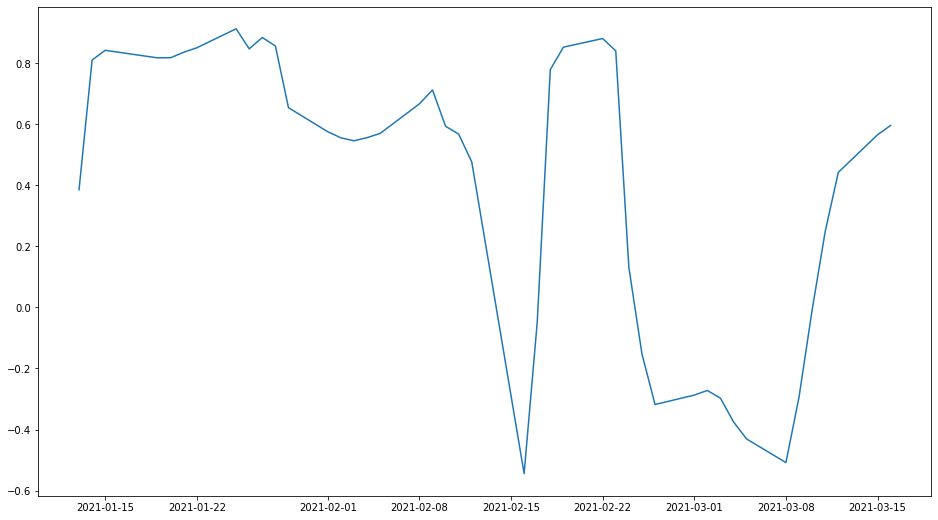

In [151]:
plt.figure(figsize=(16,9))
plt.plot(df['BB'].iloc[7:50])

In [ ]:
legends = list()
legends.append("Global")
figure = plt.figure(figsize=(16,9))
plt.plot(dist['bins'][0:-1], dist['Global'],color='black',linewidth=5)

for i in [-15,-14,-13,-12,-11]:    
    s = out.index[i]
    n,_ = np.histogram(table[s], bins=dist['bins'])
    n = n/np.sum(n)
    n = savgol_filter(n, 51, 2)
    plt.plot(dist['bins'][0:-1], n)    
    legends.append(s+":"+str(out[i]))


plt.legend(legends)

In [31]:
r.corr()

,ON,MTB,BAX,ACI,UNM,PACW,EA,AMAT,CAH,ACGL,...,GEHI,BYND,FTNT,MHK,HXL,PPC,RRX,WE,MCO,PINS
ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BAX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RRX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
column

'RF'

In [27]:
# calculate correlations for each rolling window
# pick a starting date for rolling correlations
start_date = datetime.datetime(year=2017, month=1,day=1)
window_sizes = [5]#, 10, 20, 60, 120]

# read csv from before and convert the datetime to datetime format for easy selection
df = pd.read_csv("historical_data.csv",index_col="Date")
df.index=pd.to_datetime(df.index, format='%Y-%m-%d')

data = df[df.index>start_date]

for window_size in window_sizes:
    msg = f"starting window size {window_size}"
    logger.info(msg)
    print(msg)
    os.makedirs(f'data/{window_size}',exist_ok=True)    
    res = dict()
    for column in df.columns:
        res[column] = None
    
    for col_idx, column in enumerate(data.columns):
        roll = data.rolling(window=window_size)        
        idx = 0
        for r in roll:            
            roll_msg = f"roll {idx+1} of {len(df)-window_size}"
            idx+=1        
            d = r.corr()                    
            #    msg = roll_msg + f": {column}, {col_idx+1} of {len(d.columns)}"
            #    logger.info(msg)
            #    print(msg, end='\r')            
            #    out = pd.DataFrame(np.expand_dims(d[column].to_numpy(),axis=0),columns=list(data.keys()))
            #    out['timestamp'] = r.index.max()
            #    out = out.set_index('timestamp')
            #    res[column] = pd.concat([res[column], out])
            #    table = pa.Table.from_pandas(res[column], preserve_index=True)
            #    pq.write_table(table, f'data/{window_size}/{column}.parquet')
            #    print(" "*80, end="\r")

    #with open(f'correlations_{window_size}_days.pkl', 'wb') as f:
    #	pickle.dump(res, f)


starting window size 5
